# The Goal

You have just joined the data team at an online publishing company. One of your verticals
is a food publication. A product manager on your team wants to build a feature for this vertical that enables users to query by cuisine, not just by ingredients. All of your recipes are unlabeled, and it's infeasible to label them by hand.
Design and execute a method to group the recipes by cuisine. 

<ul>
<li>How could you design this to be robust enough to understand similarities / substitutions between ingredients? </li>
<li>For each each major cuisine, what are the driving ingredients that characterize it?</li>
<li>Your product manager indicates a likelihood that you will only need to write a guideline for an outsourced team to hand label the remaining corpus. 
How would you go about writing this guide for a few major cuisines?</li>
</ul>

### FOOTNOTE: You are given 4 hours to solve this data challenge

In [45]:
#This code is to import the libraries we will ptentially be using during the execution of the tasks I have been assigned to
# data analysis and wrangling
import pandas as pd
import pickle
import numpy as np
import random as rnd
from datetime import timedelta
import scipy
from scipy import stats
#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA 
# machine learning and metrics
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, make_scorer, mean_squared_error
from sklearn.model_selection import KFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, Lasso, SGDRegressor, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor,RandomForestRegressor
from sklearn.svm import SVC, LinearSVC, SVR, LinearSVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn import svm
#libraries for clustering
from sklearn.cluster import KMeans
from sklearn import cluster
from sklearn import metrics
from sklearn.cluster import  MiniBatchKMeans
import nltk
from nltk.cluster import KMeansClusterer

#libraries for text analysis
from gensim.corpora.dictionary import Dictionary
import gensim.corpora as corpora
from gensim.models import word2vec
from sklearn.feature_extraction.text import CountVectorizer as CVEC

import warnings
warnings.filterwarnings('ignore')

import json
from pandas.io.json import json_normalize

In [2]:
#loading json file 
with open('unlabelled_recipies.json') as infile:
    recipes= json.load(infile)
recipes_ls=list(recipes['ingredients'].values())

In [23]:
#some quick check of what the data looks like. Uncomment accordingly to have specific insights 
len(recipes_ls)
type(recipes_ls[0])
type(recipes_ls[1])

39774

### Our data are basically just lists of words (ingredients). However a minimum of data exploration and cleaning can still be performed

In [4]:
#replacing caracters on strings before converting them to list
for i,j in enumerate(recipes_ls):
    if isinstance(recipes_ls[i],str):
        recipes_ls[i]=recipes_ls[i].replace("'","")
        recipes_ls[i]=recipes_ls[i].replace("[","")
        recipes_ls[i]=recipes_ls[i].replace("]","")
        recipes_ls[i]=recipes_ls[i].replace(", ",",")
        recipes_ls[i]=recipes_ls[i].replace('\d', '') # remove digits
        recipes_ls[i]=recipes_ls[i].replace('[~!@#$/.\%^&*\(\)_"\']', '') # remove punctuation
        recipes_ls[i]=recipes_ls[i].split(',')
        
#or a better alternative
#recipes_ls=recipes_ls.astype(str).apply(literal_eval)

In [39]:
#sanity check
recipes_ls[1]

['rib',
 'carrots',
 'leeks',
 'unsalted butter',
 'finely chopped onion',
 'baking potatoes',
 'dry white wine',
 'half & half',
 'water',
 'bay leaf',
 'dried thyme',
 'chicken broth',
 'saffron threads']

In [6]:
#make list of all unique ingredients

flat_all_ingredients = [item for sublist in recipes_ls for item in sublist]
    
print(len(flat_all_ingredients))
unique_ingredients = set(flat_all_ingredients)
print(len(unique_ingredients))

428326
6746


#### There are 6746 different ingredients

In [8]:
#get frequency of ingredients in the dataset
from collections import Counter
cnt = Counter()
for word in flat_all_ingredients:
    cnt[word] += 1
cnt

Counter({'pepper': 4438,
         'bacon': 620,
         'russet potatoes': 266,
         'sugar': 6434,
         'onions': 7972,
         'gochugaru': 30,
         'olive oil': 7972,
         'shredded cheddar cheese': 769,
         'kimchi': 112,
         'scallions': 1891,
         'salt': 18049,
         'rib': 59,
         'carrots': 2814,
         'leeks': 435,
         'unsalted butter': 2782,
         'finely chopped onion': 457,
         'baking potatoes': 207,
         'dry white wine': 1218,
         'half & half': 337,
         'water': 7457,
         'bay leaf': 839,
         'dried thyme': 873,
         'chicken broth': 1554,
         'saffron threads': 277,
         'freshly ground pepper': 949,
         'butter': 4848,
         'savoy cabbage': 55,
         'liqueur': 41,
         'unsweetened cocoa powder': 266,
         'grated orange': 149,
         'confectioners sugar': 395,
         'baking soda': 942,
         'fresh orange juice': 209,
         'all-purpose flou

In [40]:
#identify most common ingredients
Counter(flat_all_ingredients).most_common(15)

[('salt', 18049),
 ('onions', 7972),
 ('olive oil', 7972),
 ('water', 7457),
 ('garlic', 7380),
 ('sugar', 6434),
 ('garlic cloves', 6237),
 ('butter', 4848),
 ('ground black pepper', 4785),
 ('all-purpose flour', 4632),
 ('pepper', 4438),
 ('vegetable oil', 4385),
 ('eggs', 3388),
 ('soy sauce', 3296),
 ('kosher salt', 3113)]

#### I am going to eliminate most common ingredients under the assumptions they are common to all the cuisines. However I should check after the clustering what was the frequency distribution of cuisines in the dataset

In [43]:
#removing most common ingredients (not all of them, soy sauce makes still sense)
ingredients_array = list(['salt', 'onions','olive oil', 'water', 'garlic',
'sugar', 'garlic cloves', 'butter', 'ground black pepper','all-purpose flour','pepper',
 'vegetable oil'])
for i in range(len(recipes_ls)):
    for j in ingredients_array:
        if j in recipes_ls[i]:
            recipes_ls[i].remove(j)

#### As part of data preparation I need to convert words in vectors. For this purpose I used Word2Vec, that can capture capture the distance between individual words.

In [10]:
# Set values for NN parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 3    # 50% of the corpus                    
num_workers = 4       # Number of CPUs
context = 10          # Context window size; 
                      # let's use avg recipte size                                                                                  
downsampling = 1e-3   # threshold for configuring which 
                    # higher-frequency words are randomly downsampled

# Initialize and train the model 
model = word2vec.Word2Vec(recipes_ls, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

In [234]:
print(list(model.wv.vocab))

['pepper', 'bacon', 'russet potatoes', 'sugar', 'onions', 'gochugaru', 'olive oil', 'shredded cheddar cheese', 'kimchi', 'scallions', 'salt', 'rib', 'carrots', 'leeks', 'unsalted butter', 'finely chopped onion', 'baking potatoes', 'dry white wine', 'half & half', 'water', 'bay leaf', 'dried thyme', 'chicken broth', 'saffron threads', 'freshly ground pepper', 'butter', 'savoy cabbage', 'liqueur', 'unsweetened cocoa powder', 'grated orange', 'confectioners sugar', 'baking soda', 'fresh orange juice', 'all-purpose flour', 'ground cinnamon', 'hazelnuts', 'ground cloves', 'rice flour', 'potato flour', 'fresno chiles', 'reduced sodium soy sauce', 'rice wine', 'szechwan peppercorns', 'garlic cloves', 'peanut oil', 'dark brown sugar', 'boneless skinless chicken breasts', 'thai basil', 'kosher salt', 'lime wedges', 'salsa', 'ground black pepper', 'green bell pepper', 'fresh lime juice', 'vegetable oil', 'lean steak', 'chopped cilantro fresh', 'flour tortillas', 'lemon', 'large garlic cloves', '

In [12]:
X = model[model.wv.vocab]

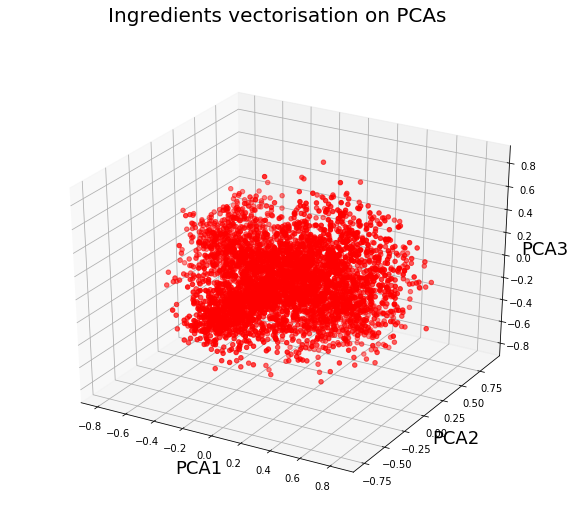

In [16]:
# I am using PCA to get a space represantation of the ingredients' space

# And plot them by using a PCA approach and pyplot.

#pca = PCA(n_components=50)
pca = PCA(n_components=10)
result = pca.fit_transform(X)
from mpl_toolkits.mplot3d.axes3d import get_test_data
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig= plt.figure(figsize=(10, 8))
plt.suptitle('Ingredients vectorisation on PCAs', fontsize=20)
ax = fig.add_subplot(111, projection='3d')

x=ax.set_xlabel('PCA1', fontsize=18)
y=ax.set_ylabel('PCA2', fontsize=18)
z=ax.set_zlabel('PCA3', fontsize=18)
ax.scatter(result[:, 0], result[:, 1], result[:,2], c='r', marker='o')
#give the labels to each point
# Uncomment the following lines to have the keywords annotated on the graph
#words = list(model.wv.vocab)
#words = [w.replace('_', ' ') for w in words]   
#for x, y, z, word in zip(result[:, 0], result[:, 1], result[:,2], words):
    #ax.text(x, y, z, word)

plt.show()

#### Now ingredients are vectors. However I am interested in recipes' vectors, not just ingredients vectors 

In [11]:
# let's define a function that add vectors based on the presence
#or not of the associated word to the list
def recipe2vec(recipe): # 'word' meaning ingredient in "recipe" which is a list of ingredients
    #if len(recipe)<2:recipe='oddword'
    vec = np.sum( [model.wv[word]
                                for word in recipe if word in model.wv.vocab] or
                 [np.zeros(300, dtype=float)
                            for word in recipe if word not in model.wv.vocab],axis=0)
    return vec
# applying the function to our recipes list
vectorall = np.array([recipe2vec(recipe) for recipe in recipes_ls])

#### Now I can attempt to cluster recipes. I will use Kmeans

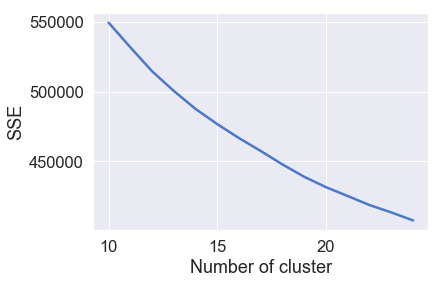

In [47]:
#Using elbow plot to guess the number of clusters
sse = {}
for k in range(10, 25):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(vectorall)
    #data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [ ]:
NUM_CLUSTERS=25
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(vectorall, assign_clusters=True)
#print (assigned_clusters)
kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(vectorall)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
 
silhouette_score = metrics.silhouette_score(vectorall, labels, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)


In [ ]:
LABEL_COLOR_MAP = {0 : 'r',
                   1 : 'k',
                   2 : 'b',
                   3 : 'g',
                   4 : 'y',
                   
                   }

label_color = [LABEL_COLOR_MAP[l] for l in labels]
plt.scatter(x, y, c=label_color)